# Compute transformation due to SW from GOES data

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import dask
import dask.array as dsa
from xgcm import Grid
import xgcm 
from xgcm.autogenerate import generate_grid_ds
from xhistogram.xarray import histogram
import pandas as pd

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GOES/datasets/sw_ds.zarr'))

In [3]:
ds

<xarray.Dataset>
Dimensions:                          (t: 37665, lat: 18, lon: 56)
Coordinates:
    dsr_product_wavelength           float32 ...
  * lat                              (lat) float64 30.75 30.25 ... 22.75 22.25
    lat_image                        float32 ...
  * lon                              (lon) float64 -99.75 -99.25 ... -72.25
    lon_image                        float32 ...
    quantitative_local_zenith_angle  float32 ...
    quantitative_solar_zenith_angle  float32 ...
    retrieval_local_zenith_angle     float32 ...
    retrieval_solar_zenith_angle     float32 ...
  * t                                (t) datetime64[ns] 2019-12-05T16:05:05.2...
Data variables:
    DQF                              (t, lat, lon) float32 dask.array<chunksize=(37665, 18, 56), meta=np.ndarray>
    DSR                              (t, lat, lon) float32 dask.array<chunksize=(37665, 18, 56), meta=np.ndarray>
Attributes: (12/21)
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    cdm_data_type:             Image
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    instrument_ID:             FM1
    iso_series_metadata_id:    de00d810-b013-11e1-afa6-0800200c9a66
    ...                        ...
    project:                   GOES
    scene_id:                  Full Disk
    spatial_resolution:        50km at nadir
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    summary:                   The Downward Shortwave Radiation: Surface prod...
    title:                     ABI L2 Downward Shortwave Radiation: Surface

In [4]:
#rename t->time
goes = ds.assign_coords({'time':ds.t}).swap_dims({'t':'time'}).drop_vars('t')
#assign sw obj
sw_unsliced = goes.DSR.resample(time='D').mean()
#slice to just 2023
sw = sw_unsliced.sel(time=slice('2023-01', '2023-12'))

In [5]:
sw

<xarray.DataArray 'DSR' (time: 365, lat: 18, lon: 56)>
dask.array<getitem, shape=(365, 18, 56), dtype=float32, chunksize=(365, 18, 56), chunktype=numpy.ndarray>
Coordinates:
    dsr_product_wavelength           float32 ...
  * lat                              (lat) float64 30.75 30.25 ... 22.75 22.25
    lat_image                        float32 ...
  * lon                              (lon) float64 -99.75 -99.25 ... -72.25
    lon_image                        float32 ...
    quantitative_local_zenith_angle  float32 ...
    quantitative_solar_zenith_angle  float32 ...
    retrieval_local_zenith_angle     float32 ...
    retrieval_solar_zenith_angle     float32 ...
  * time                             (time) datetime64[ns] 2023-01-01 ... 202...
Attributes:
    ancillary_variables:  DQF
    cell_methods:         retrieval_local_zenith_angle: point (good or degrad...
    grid_mapping:         goes_lat_lon_projection
    long_name:            ABI L2+ Downward Shortwave Radiation: Surface
    resolution:           lon: 0.5 degree lat: 0.5 degree
    standard_name:        surface_downwelling_shortwave_flux_in_air
    units:                W m-2

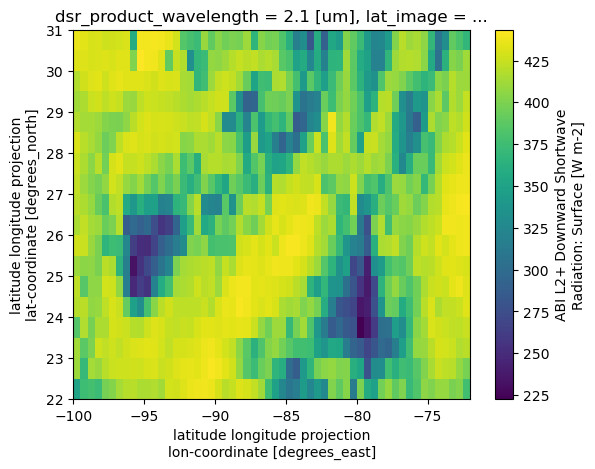

In [6]:
sw.sel(time='2023-08-15').plot()

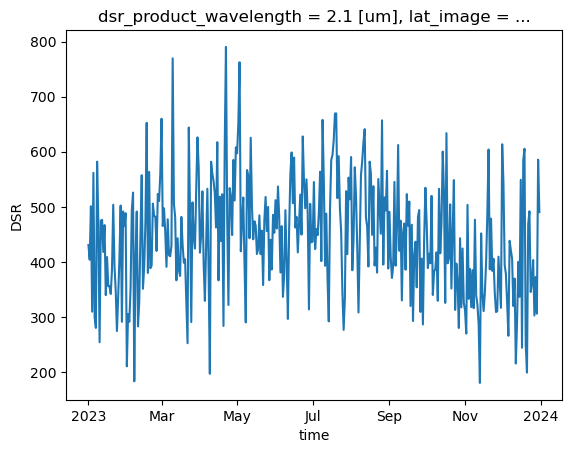

In [7]:
sw.mean(['lat', 'lon']).plot()

## Create grid and area objects

In [9]:
ds_full = generate_grid_ds(ds, {'X':'lon', 'Y':'lat'})

In [10]:
ds_full

<xarray.Dataset>
Dimensions:                          (t: 37665, lat: 18, lon: 56, lon_left: 56,
                                      lat_left: 18)
Coordinates:
    dsr_product_wavelength           float32 ...
  * lat                              (lat) float64 30.75 30.25 ... 22.75 22.25
    lat_image                        float32 ...
  * lon                              (lon) float64 -99.75 -99.25 ... -72.25
    lon_image                        float32 ...
    quantitative_local_zenith_angle  float32 ...
    quantitative_solar_zenith_angle  float32 ...
    retrieval_local_zenith_angle     float32 ...
    retrieval_solar_zenith_angle     float32 ...
  * t                                (t) datetime64[ns] 2019-12-05T16:05:05.2...
  * lon_left                         (lon_left) float64 -100.0 -99.5 ... -72.5
  * lat_left                         (lat_left) float64 31.0 30.5 ... 23.0 22.5
Data variables:
    DQF                              (t, lat, lon) float32 dask.array<chunksize=(37665, 18, 56), meta=np.ndarray>
    DSR                              (t, lat, lon) float32 dask.array<chunksize=(37665, 18, 56), meta=np.ndarray>
Attributes: (12/21)
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    cdm_data_type:             Image
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    instrument_ID:             FM1
    iso_series_metadata_id:    de00d810-b013-11e1-afa6-0800200c9a66
    ...                        ...
    project:                   GOES
    scene_id:                  Full Disk
    spatial_resolution:        50km at nadir
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    summary:                   The Downward Shortwave Radiation: Surface prod...
    title:                     ABI L2 Downward Shortwave Radiation: Surface

In [13]:
grid = xgcm.Grid(ds_full, periodic=['X'])
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> left
  * left     lon_left --> center
Y Axis (not periodic, boundary=None):
  * center   lat --> left
  * left     lat_left --> center
T Axis (not periodic, boundary=None):
  * center   t

In [14]:
def deg_2_m(grid_obj, ds_obj, lat, lon):
    #calculating meters per latitudinal & longitudinal degree
    earth_radius = 6.371e6
    earth_circumference = 2*np.pi*earth_radius
    meters_per_degree = earth_circumference / 360
    meters_per_degree
    
    #converting lat from degrees to meters
    delta_lat = grid_obj.diff(ds_obj[f'{lat}'], 'Y', boundary='fill', fill_value=np.nan)
    dy = delta_lat * meters_per_degree
    delta_lat_l = grid_obj.diff(ds_obj[f'{lat}_left'], 'Y', boundary='fill', fill_value=np.nan)
    dy_l = delta_lat_l * meters_per_degree

    #converting degrees lon to lon [meters] (pinching at the poles)
    delta_lon = grid_obj.diff(ds_obj[f'{lon}'], 'X')#, boundary_discontinuity=360)
    dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}']))
    delta_lon_l = grid_obj.diff(ds_obj[f'{lon}_left'], 'X')#, boundary_discontinuity=360)
    dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}_left']))
    
    elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])
    
    return (elements)

In [15]:
cell_elements = deg_2_m(grid, ds_full, 'lat', 'lon')

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [20]:
cell_elements.dx_l

<xarray.DataArray 'dx_l' (lon: 56, lat_left: 18)>
array([[   47656.32756184,    47904.39564505,    48148.81562307, ...,
           50986.21384995,    51177.7348278 ,    51365.358423  ],
       [   47656.32756184,    47904.39564505,    48148.81562307, ...,
           50986.21384995,    51177.7348278 ,    51365.358423  ],
       [   47656.32756184,    47904.39564505,    48148.81562307, ...,
           50986.21384995,    51177.7348278 ,    51365.358423  ],
       ...,
       [   47656.32756184,    47904.39564505,    48148.81562307, ...,
           50986.21384995,    51177.7348278 ,    51365.358423  ],
       [   47656.32756184,    47904.39564505,    48148.81562307, ...,
           50986.21384995,    51177.7348278 ,    51365.358423  ],
       [-2621098.01590136, -2634741.76047798, -2648184.85926871, ...,
        -2804241.76174745, -2814775.41552912, -2825094.71326505]])
Coordinates:
    dsr_product_wavelength           float32 2.1
    lat_image                        float32 0.0
    lon_image                        float32 -75.0
    quantitative_local_zenith_angle  float32 70.0
    quantitative_solar_zenith_angle  float32 70.0
    retrieval_local_zenith_angle     float32 90.0
    retrieval_solar_zenith_angle     float32 90.0
  * lon                              (lon) float64 -99.75 -99.25 ... -72.25
  * lat_left                         (lat_left) float64 31.0 30.5 ... 23.0 22.5

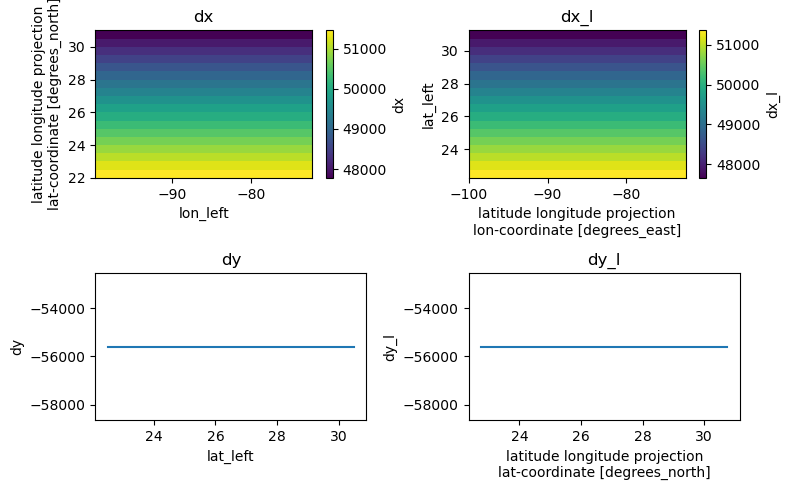

In [21]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements.dx[1:].T.plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements.dx_l[:-1].T.plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

# Run histogram

In [29]:
sw

<xarray.DataArray 'DSR' (time: 365, lat: 18, lon: 56)>
dask.array<getitem, shape=(365, 18, 56), dtype=float32, chunksize=(365, 18, 56), chunktype=numpy.ndarray>
Coordinates:
    dsr_product_wavelength           float32 ...
  * lat                              (lat) float64 30.75 30.25 ... 22.75 22.25
    lat_image                        float32 ...
  * lon                              (lon) float64 -99.75 -99.25 ... -72.25
    lon_image                        float32 ...
    quantitative_local_zenith_angle  float32 ...
    quantitative_solar_zenith_angle  float32 ...
    retrieval_local_zenith_angle     float32 ...
    retrieval_solar_zenith_angle     float32 ...
  * time                             (time) datetime64[ns] 2023-01-01 ... 202...
Attributes:
    ancillary_variables:  DQF
    cell_methods:         retrieval_local_zenith_angle: point (good or degrad...
    grid_mapping:         goes_lat_lon_projection
    long_name:            ABI L2+ Downward Shortwave Radiation: Surface
    resolution:           lon: 0.5 degree lat: 0.5 degree
    standard_name:        surface_downwelling_shortwave_flux_in_air
    units:                W m-2

In [40]:
dx_interp = grid.interp(cell_elements.dx_l, 'Y')
area = dx_interp * cell_elements.dy_l[1:]

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [43]:
area.coords

Coordinates:
  * lat                              (lat) float64 30.25 29.75 ... 22.75 22.25
  * lon                              (lon) float64 -99.75 -99.25 ... -72.25
    dsr_product_wavelength           float32 2.1
    lat_image                        float32 0.0
    lon_image                        float32 -75.0
    quantitative_local_zenith_angle  float32 70.0
    quantitative_solar_zenith_angle  float32 70.0
    retrieval_local_zenith_angle     float32 90.0
    retrieval_solar_zenith_angle     float32 90.0

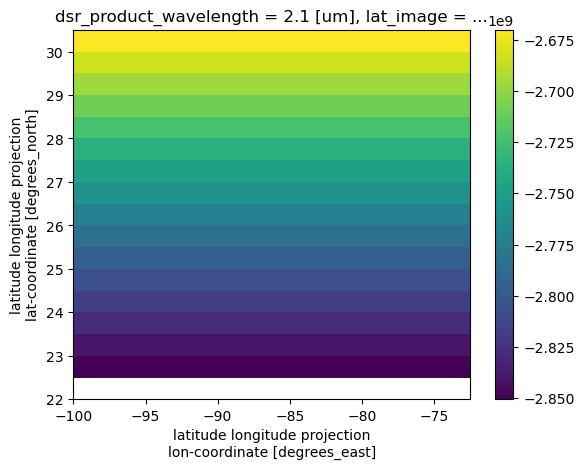

In [48]:
area[:-1].T.plot()

In [28]:
np.diff(sw.time)/1e9

array([86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400,

In [56]:
era = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/sw_sst.zarr'))
gulf = dict(longitude=slice(-99.75, -72.25), latitude=slice(22.5, 30.75))
sst = (era.sst.sel(**gulf).sel(time=slice('2023-01', None))-273.15)
theta_resampled = sst.resample(time='D').mean()

In [57]:
theta_resampled

<xarray.DataArray 'sst' (time: 316, latitude: 34, longitude: 111)>
dask.array<transpose, shape=(316, 34, 111), dtype=float32, chunksize=(299, 34, 111), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 22.5 22.75 23.0 23.25 ... 30.25 30.5 30.75
  * longitude  (longitude) float32 -99.75 -99.5 -99.25 ... -72.75 -72.5 -72.25
  * time       (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-11-12

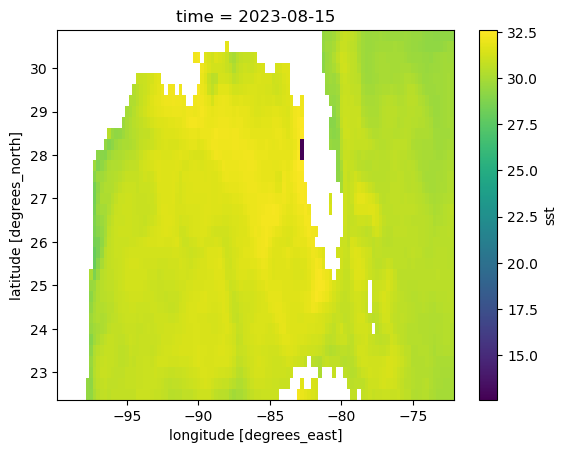

In [59]:
theta_resampled.sel(time='2023-08-15', method='nearest').plot()